This notebook looks at the "vote decay" of users. The New Yorker caption contest organizer, Bob Mankoff, has received many emails like the one below (name/personal details left out for anonymity)

> Here's my issue. 
>
> First time I encounter something, I might say it's funny. 
>
> Then it comes back in many forms over and over and it's no longer funny and I wish I could go back to the first one and say it's not funny. 
>
> But it's funny, and then I can't decide whether to credit everyone with funny or keep hitting unfunny. What I really like to find out is who submitted it first, but often it's slightly different and there may be a best version. Auggh!
>
> How should we do this???

We can investigate this: we have all the data at hand. We record the timestamp, participant ID and their rating for a given caption. So let's see how votes go after a user has seen $n$ captions!

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')

In [3]:
import caption_contest_data as ccd

## Reading in data
Let's read in the data. As the last column can contain a non-escaped comma, we have to fix that before doing any analysis.

Note that two versions of this notebook exist (the previous notebook can be found in [43bc5d]). This highlights some of the differences required to read in the earlier datasets.

[43bc5d]:https://github.com/nextml/caption-contest-data/commit/43bc5d23ee287b8b34cc4eb0181484bd21bbd341

In [5]:
contest = '540'
responses = ccd.responses(540, path="../contests/responses")
print(len(responses))
responses.head()

452547


,alg_label,network_delay,participant_uid,response_time,target,target_id,target_reward,timestamp_query_generated,label,contest,filename
0,RandomSampling,0.094617,d43d742e06d25413ea83b2572248c2_hn5JVUAQmZ6YOgB...,5.051,Don't worry. You are safe with me.,360,1,2016-10-11 18:06:45.916540,unfunny,540,540-responses.csv
1,RandomSampling,0.099862,d43d742e06d25413ea83b2572248c2_hn5JVUAQmZ6YOgB...,5.884,"I promise, all pre-existing conditions will no...",2104,1,2016-10-11 18:06:51.124120,unfunny,540,540-responses.csv
2,RandomSampling,0.089427,d43d742e06d25413ea83b2572248c2_hn5JVUAQmZ6YOgB...,2.103,You and me make a great combination Doc!,4206,1,2016-10-11 18:06:57.181677,unfunny,540,540-responses.csv
3,RandomSampling,0.087867,d43d742e06d25413ea83b2572248c2_hn5JVUAQmZ6YOgB...,4.746,"Zika? No, you're safe.",412,1,2016-10-11 18:06:59.441917,unfunny,540,540-responses.csv
4,RandomSampling,0.089464,d43d742e06d25413ea83b2572248c2_hn5JVUAQmZ6YOgB...,15.780,Click ... to the right; click... to the left. ...,4415,1,2016-10-11 18:07:04.330232,unfunny,540,540-responses.csv


## Seeing how many captions a user has seen
This is the workhorse of the notebook: it sees how many captions one participant has seen. I sorted by timestamp (and with an actual timestamp, not a str) to collect the ratings in the order a user has seen. I do not assume that only one user answers at a time.

In [6]:
last_id = None
i = 0
num_responses = []
captions_seen = []
responses = responses.sort_values(by='timestamp_query_generated')
# responses = responses[0:1000]  # debug

In [7]:
captions_seen_by = {}
captions_seen = []
for _, response in responses.iterrows():
    id_, rating = response['participant_uid'], response['target_reward']
    if id_ not in captions_seen_by:
        captions_seen_by[id_] = 0
    captions_seen_by[id_] += 1
    captions_seen += [captions_seen_by[id_]]
    num_responses += [i]

In [8]:
responses['number of captions seen'] = captions_seen
responses.head()

,alg_label,network_delay,participant_uid,response_time,target,target_id,target_reward,timestamp_query_generated,label,contest,filename,number of captions seen
252687,RandomSampling,0.071828,d43d742e06d25413ea83b2572248c2_EKjDKfTX9LNM2MT...,4.557,You probably wouldn't even be here if you had ...,1490,1,2016-10-10 17:21:45.573372,unfunny,540,540-responses.csv,1
252688,RandomSampling,0.076773,d43d742e06d25413ea83b2572248c2_EKjDKfTX9LNM2MT...,14.824,I guess I don't need to apologize for my cold ...,2883,1,2016-10-10 17:21:50.381564,unfunny,540,540-responses.csv,2
252689,RandomSampling,0.142236,d43d742e06d25413ea83b2572248c2_EKjDKfTX9LNM2MT...,4.752,"I'm sorry but your tumblers are dry, your pett...",3923,1,2016-10-10 17:22:05.504520,unfunny,540,540-responses.csv,3
252690,RandomSampling,0.070380,d43d742e06d25413ea83b2572248c2_EKjDKfTX9LNM2MT...,3.380,New and improved provider reimbursement under ...,271,1,2016-10-10 17:22:10.584019,unfunny,540,540-responses.csv,4
252691,RandomSampling,0.068067,d43d742e06d25413ea83b2572248c2_EKjDKfTX9LNM2MT...,2.258,Try a more balanced diet . . . your acid test ...,3686,1,2016-10-10 17:22:14.221277,unfunny,540,540-responses.csv,5


## Viewing the data
Now let's format the data to view it. We can view the data in two ways: as we only have three rating values, we can view the probability of a person rating 1, 2 or 3, and can also view the mean.

In this, we rely on `pd.pivot_table`. This can take DataFrame that looks like a list of dictionaries and compute `aggfunc` (by default `np.mean`) for all items that contain common keys (indicated by `index` and `columns`). It's similar to Excel's pivot table functionality.

### Probability of rating {1, 2, 3}

In [9]:
def prob(x):
    n = len(x)
    ret = {'n': n}
    ret.update({name: np.sum(x == i) for name, i in [('unfunny', 1),
                                                  ('somewhat funny', 2),
                                                  ('funny', 3)]})
    return ret

probs = responses.pivot_table(index='number of captions seen',
                              columns='alg_label', values='target_reward',
                              aggfunc=prob)
probs.head()

alg_label,RandomSampling
number of captions seen,
1,"{'n': 8076, 'unfunny': 5154, 'somewhat funny':..."
2,"{'n': 7663, 'unfunny': 5319, 'somewhat funny':..."
3,"{'n': 7390, 'unfunny': 5208, 'somewhat funny':..."
4,"{'n': 7142, 'unfunny': 5045, 'somewhat funny':..."
5,"{'n': 6915, 'unfunny': 4968, 'somewhat funny':..."


In [10]:
d = {label: dict(probs[label]) for label in ['RandomSampling']}
for label in d.keys():
    for n in d[label].keys():
        if d[label][n] is None:
            continue
        for rating in ['unfunny', 'somewhat funny', 'funny']:
            d[label][n][rating] = d[label][n][rating] / d[label][n]['n']

In [11]:
df = pd.DataFrame(d['RandomSampling']).T
df = pd.concat({'RandomSampling': df}, axis=1)
df.head()

RandomSampling                                   
               n   unfunny somewhat funny     funny
1         8076.0  0.638187       0.273774  0.088039
2         7663.0  0.694115       0.235808  0.070077
3         7390.0  0.704736       0.217321  0.077943
4         7142.0  0.706385       0.221367  0.072249
5         6915.0  0.718438       0.201446  0.080116

(0, 100)

(0, 100)

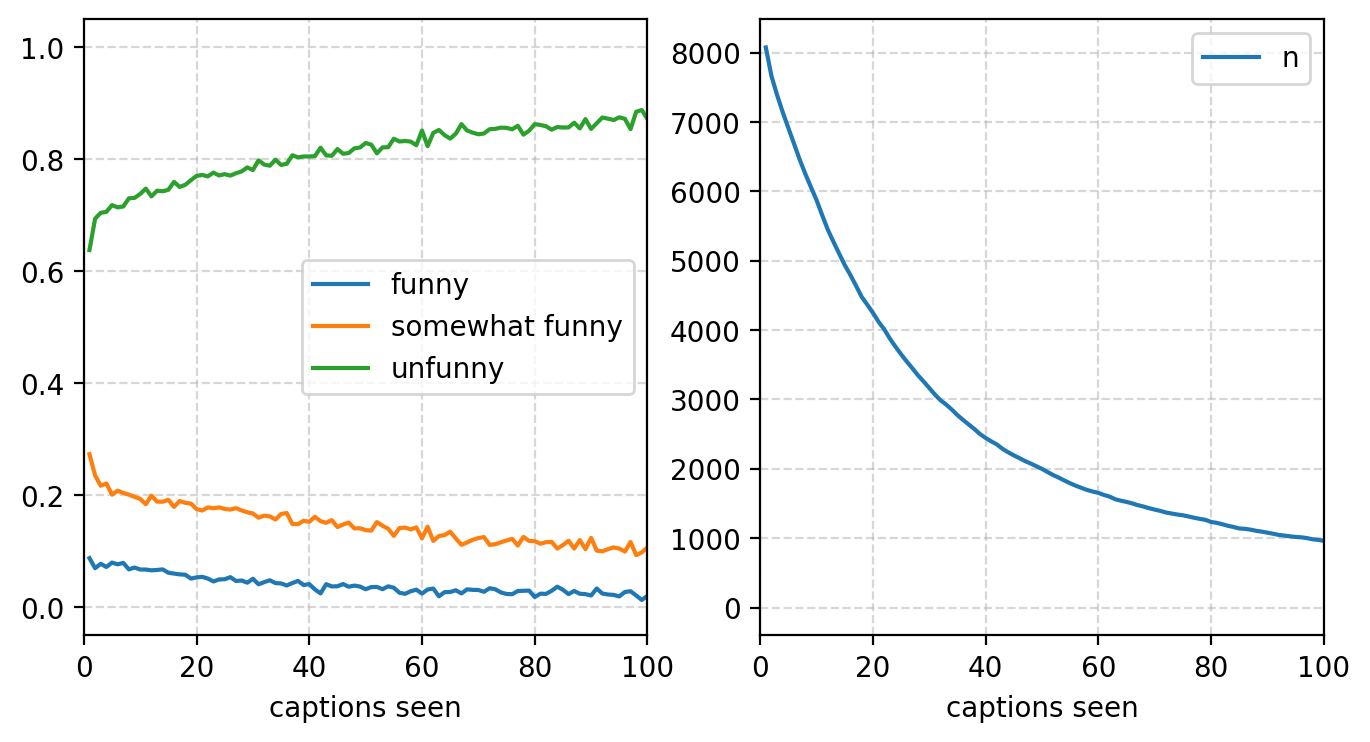

In [12]:
plt.style.use("default")

fig, axs = plt.subplots(figsize=(8, 4), ncols=2)

alg = "RandomSampling"
show = df[alg].copy()
show["captions seen"] = show.index

for y in ["funny", "somewhat funny", "unfunny"]:
    show.plot(x="captions seen", y=y, ax=axs[0])
show.plot(x="captions seen", y="n", ax=axs[1])

for ax in axs:
    ax.set_xlim(0, 100)
    ax.grid(linestyle='--', alpha=0.5)


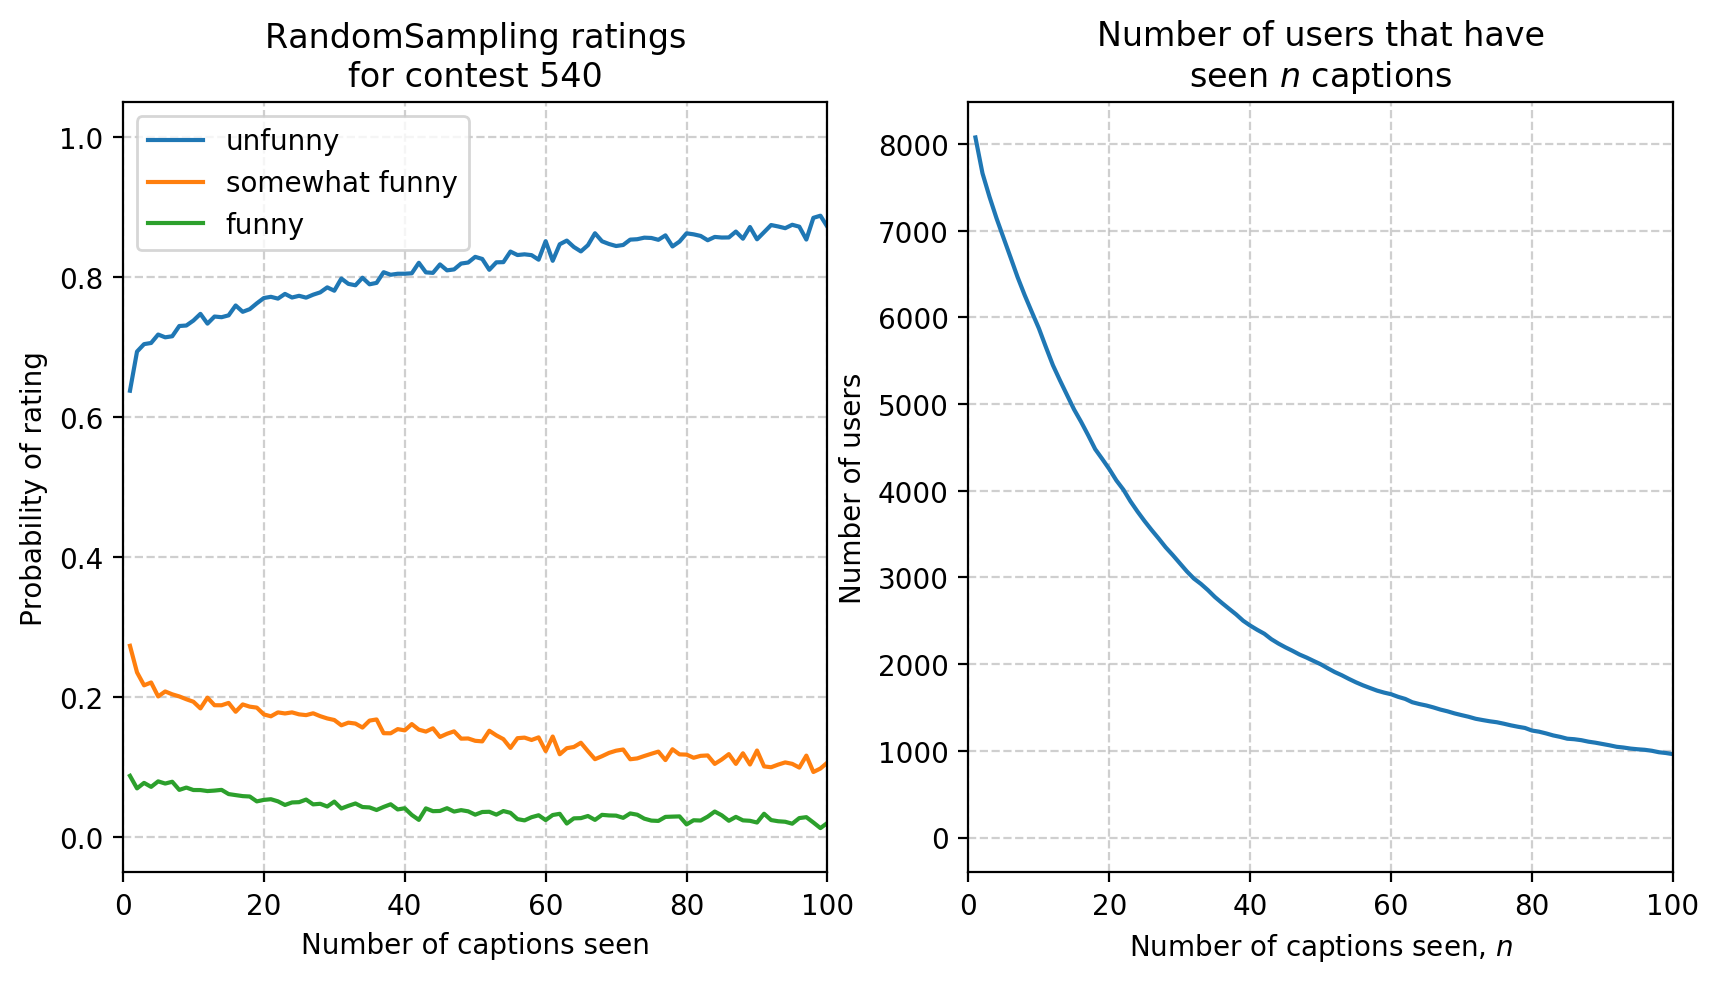

In [13]:
plt.style.use("default")

def plot(alg):
    fig = plt.figure(figsize=(10, 5))
    ax = plt.subplot(1, 2, 1)
    df[alg][['unfunny', 'somewhat funny', 'funny']].plot(ax=ax)
    plt.xlim(0, 100)
    plt.title('{} ratings\nfor contest {}'.format(alg, contest))
    plt.ylabel('Probability of rating')
    plt.xlabel('Number of captions seen')
    plt.grid(linestyle="--", alpha=0.6)

    ax = plt.subplot(1, 2, 2)
    df[alg]['n'].plot(ax=ax, logy=False)
    plt.ylabel('Number of users')
    plt.xlabel('Number of captions seen, $n$')
    plt.title('Number of users that have\nseen $n$ captions')
    plt.xlim(0, 100)
    plt.grid(linestyle="--", alpha=0.6)
    
for alg in ['RandomSampling']:
    fig = plot(alg)
    plt.show()